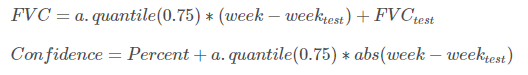

# ConvNets for Cofficient a Prediction

### InceptionV3

In [1]:
import os
import cv2
import pydicom
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import keras.applications as tfa

Using TensorFlow backend.


# Load and Transform Data

In [2]:
train = pd.read_csv('D:/CSE499/osic-pulmonary-fibrosis-progression/train.csv') 

In [3]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
def get_tab(df):
    " raturn an array which contains each patient normalized age, sex and smoking status"
    vector = [(df.Age.values[0] - 49) / (88 - 49)] 
    
    if df.Sex.values[0].lower() == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [5]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())): # i index, p patient id
    sub = train.loc[train.Patient == p, :] # find all data (weeks, FVC, Percent, Age, Sex, SmokingStatus) of a unique patient
    fvc = sub.FVC.values # fvc values of the patient during the follow-up
    weeks = sub.Weeks.values # follow-up weeks
    c = np.vstack([weeks, np.ones(len(weeks))]).T # create an array by the follow-up weeks of shape(len(weeks),2)
    a, b = np.linalg.lstsq(c, fvc)[0] # least-square sol, a=gradient matrix, b=right hand matrix 
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

C:\Users\Monir\anaconda3\envs\rabbi36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [6]:
print(c)

[[ 0.  1.]
 [ 7.  1.]
 [ 9.  1.]
 [11.  1.]
 [13.  1.]
 [19.  1.]
 [31.  1.]
 [43.  1.]
 [59.  1.]]


In [7]:
def get_img(path):
    " read DICOM dataset and return resize images of size (512,512,1)"
    d = pydicom.dcmread(path) # read and parse the CT scan images (in DICOM format)
    resized_image = cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512,512))
    return resized_image

In [8]:
from keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size):
        "key=patient, a=gradient matrix, tab=a particular patient's data"
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chooses n=batch_size number of patients
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0] # chooses some randomly images for kth patient
                img = get_img(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{k}/{i}') # resizes ith image of kth patient
                x.append(img) # append kth patient's image data in the list x
                a.append(self.a[k]) # append kth patient's gradinet in the list a
                tab.append(self.tab[k]) # append kth patient's tabular data in the tab list
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab) # convert list to array
        x = np.expand_dims(x, axis=-1) 
        return [x, tab] , a

# Build the Model

In [9]:
from keras.applications import resnet50, vgg16, inception_v3
from keras import Model
from keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, 
    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate 
)

In [10]:
def get_model(model, shape):
    models_dict = {
        'InceptionV3': inception_v3.InceptionV3(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_model(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,)) # indicates that the expected input will be batches of 4-dimensional vectors
    x2 = GaussianNoise(0.3)(inp2) # to mitigate overfitting
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

In [11]:
MODEL_CLASS = 'InceptionV3'
base_model = build_model(shape=(512, 512, 1), model_class=MODEL_CLASS)
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 14, 14, 2048) 21802208    input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           inception_v3[1][0]               
____________________________________________________________________________________________

# Compile and Train the Model

In [12]:
BATCH_SIZE = 2
EPOCHS = 80
LR = 0.001
SAVE_BEST = True

In [13]:
import keras
P = np.array(P)
subs = []
folds_history = []

"""
er = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3,patience=15,verbose=1,mode="auto",baseline=None,
      restore_best_weights=True,) #Stop training when a monitored metric has stopped improving.
"""

cpt = keras.callbacks.ModelCheckpoint(filepath=f'C:/Users/Monir/Documents/CSE499/models/Inception/{MODEL_CLASS}_{EPOCHS}_epochs.h5',monitor='val_loss',verbose=1, 
    save_best_only=SAVE_BEST,mode='auto') #to save model or weights in a checkpoint file at lowest validation loss

rlp = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5, verbose=1, min_lr=1e-8) 
     #Reduce learning rate when a metric has stopped improving.
     # if improvement stops, after 5 epochs learning rate will be reduced

model = build_model(model_class=MODEL_CLASS)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss="mae") 
history = model.fit(IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE), 
                    steps_per_epoch = 32,
                    validation_data=IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE),
                    validation_steps = 16, 
                    callbacks = [cpt, rlp], 
                    epochs=EPOCHS)
folds_history.append(history.history)
print('Training Complete!!!')

Epoch 1/80
32/32 [==============================] - 39s 1s/step - loss: 4.2607 - val_loss: 1.4350

Epoch 00001: val_loss improved from inf to 1.43503, saving model to C:/Users/Monir/Documents/CSE499/models/Inception/InceptionV3_80_epochs.h5
Epoch 2/80
32/32 [==============================] - 6s 184ms/step - loss: 3.7850 - val_loss: 3.6902

Epoch 00002: val_loss did not improve from 1.43503
Epoch 3/80
32/32 [==============================] - 6s 183ms/step - loss: 3.4008 - val_loss: 3.1315

Epoch 00003: val_loss did not improve from 1.43503
Epoch 4/80
32/32 [==============================] - 6s 185ms/step - loss: 4.5655 - val_loss: 1.5370

Epoch 00004: val_loss did not improve from 1.43503
Epoch 5/80
32/32 [==============================] - 6s 184ms/step - loss: 4.6014 - val_loss: 5052.0518

Epoch 00005: val_loss did not improve from 1.43503
Epoch 6/80
32/32 [==============================] - 6s 184ms/step - loss: 4.3272 - val_loss: 44.9577

Epoch 00006: val_loss did not improve from 1.4

32/32 [==============================] - 6s 184ms/step - loss: 4.1764 - val_loss: 0.8466

Epoch 00048: val_loss did not improve from 0.44423
Epoch 49/80
32/32 [==============================] - 6s 185ms/step - loss: 3.6529 - val_loss: 12.5593

Epoch 00049: val_loss did not improve from 0.44423
Epoch 50/80
32/32 [==============================] - 6s 185ms/step - loss: 4.2424 - val_loss: 7.9543

Epoch 00050: val_loss did not improve from 0.44423
Epoch 51/80
32/32 [==============================] - 6s 185ms/step - loss: 4.7994 - val_loss: 6.3908

Epoch 00051: val_loss did not improve from 0.44423
Epoch 52/80
32/32 [==============================] - 6s 185ms/step - loss: 4.7048 - val_loss: 2.1448

Epoch 00052: val_loss did not improve from 0.44423

Epoch 00052: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 53/80
32/32 [==============================] - 6s 189ms/step - loss: 4.2496 - val_loss: 2.6794

Epoch 00053: val_loss did not improve from 0.44423
Epoch 54/80

# Save Model History

In [14]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'Inception_history_80_epoch.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'Inception_history_80_epoch.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Visualize Training Results 

In [15]:
result_dir = 'C:/Users/Monir/Documents/CSE499/results_and_figures/Inception/'

import tikzplotlib
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

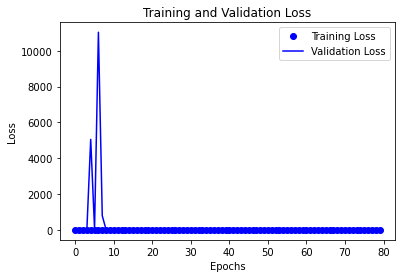

In [16]:
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.savefig(result_dir + 'Inception_loss_80_epoch.png')
plt.savefig(result_dir + 'Inception_loss_80_epoch.pdf', dpi=150)
tikzplotlib.save(result_dir + 'Inception_loss_80_epoch.tex', encoding='utf-8')

plt.show()

In [17]:
def smooth_curve(points, factor=0.95):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

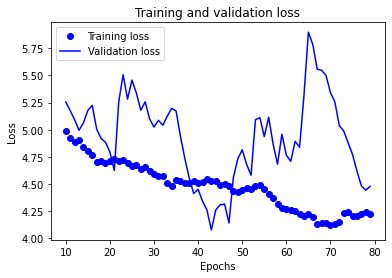

In [18]:
epochs_range = range(10,EPOCHS)
plt.plot(epochs_range,
         smooth_curve(loss[10:]), 'bo', label='Training loss')
plt.plot(epochs_range,smooth_curve(val_loss[10:]), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(result_dir + 'Inception_loss_smooth_80_epoch.png')
plt.savefig(result_dir + 'Inception_loss_smooth_80_epoch.pdf', dpi=150)
tikzplotlib.save(result_dir + 'Inception_loss_smooth_80_epoch.tex', encoding='utf-8')

plt.show()

# Quantile Regression to calculate quantile

In [19]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [20]:
from tqdm.notebook import tqdm

validation_data=IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE)

metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in validation_data:
        x = [] 
        tab = [] 
        
        if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue
        for i in os.listdir(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{p}/'):
            x.append(get_img(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        tab = np.array(tab) 
    
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        print("shape(_a): ",shape(_a))
        a = np.quantile(_a, q / 10) # quantile regression on the prediction 
        print("a: ", a)
        
        percent_true = train.Percent.values[train.Patient == p]
        fvc_true = train.FVC.values[train.Patient == p]
        weeks_true = train.Weeks.values[train.Patient == p]
        
        fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
        percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
        m.append(score(fvc_true, fvc, percent))
    print(np.mean(m))
    metric.append(np.mean(m))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/CSE499/osic-pulmonary-fibrosis-progression/train/([array([[[[-1.024],\n         [-1.024],\n         [-1.024],\n         ...,\n         [-1.024],\n         [-1.024],\n         [-1.024]],\n\n        [[-1.024],\n         [-1.024],\n         [-1.024],\n         ...,\n         [-1.024],\n         [-1.024],\n         [-1.024]],\n\n        [[-1.024],\n         [-1.024],\n         [-1.024],\n         ...,\n         [-1.024],\n         [-1.024],\n         [-1.024]],\n\n        ...,\n\n        [[-1.024],\n         [-1.024],\n         [-1.024],\n         ...,\n         [-1.024],\n         [-1.024],\n         [-1.024]],\n\n        [[-1.024],\n         [-1.024],\n         [-1.024],\n         ...,\n         [-1.024],\n         [-1.024],\n         [-1.024]],\n\n        [[-1.024],\n         [-1.024],\n         [-1.024],\n         ...,\n         [-1.024],\n         [-1.024],\n         [-1.024]]],\n\n\n       [[[ 1.054],\n         [ 1.065],\n         [ 1.024],\n         ...,\n         [ 1.099],\n         [ 1.084],\n         [ 1.024]],\n\n        [[ 1.09 ],\n         [ 1.024],\n         [ 1.129],\n         ...,\n         [ 1.061],\n         [ 1.058],\n         [ 1.029]],\n\n        [[ 1.039],\n         [ 1.049],\n         [ 1.085],\n         ...,\n         [ 1.024],\n         [ 1.091],\n         [ 1.024]],\n\n        ...,\n\n        [[ 1.233],\n         [ 1.038],\n         [ 1.025],\n         ...,\n         [ 1.885],\n         [ 1.777],\n         [ 1.276]],\n\n        [[ 1.2  ],\n         [ 1.024],\n         [ 1.042],\n         ...,\n         [ 1.609],\n         [ 1.14 ],\n         [ 1.024]],\n\n        [[ 1.143],\n         [ 1.024],\n         [ 1.053],\n         ...,\n         [ 1.024],\n         [ 1.135],\n         [ 1.024]]]]), array([[0.87179487, 0.        , 0.        , 0.        ],\n       [1.        , 0.        , 1.        , 1.        ]])], array([-2.90423317, -5.58589663]))/'